In [78]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.qmc as qmc

<code style="background:LightBlue;color:white"> <strong><em> Data generation </em> </strong> 

In [25]:
def generation(n, alpha=1, beta=0, gamma=1, delta=0):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0,1))
        
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [62]:
n=10000
y_obs = generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10)

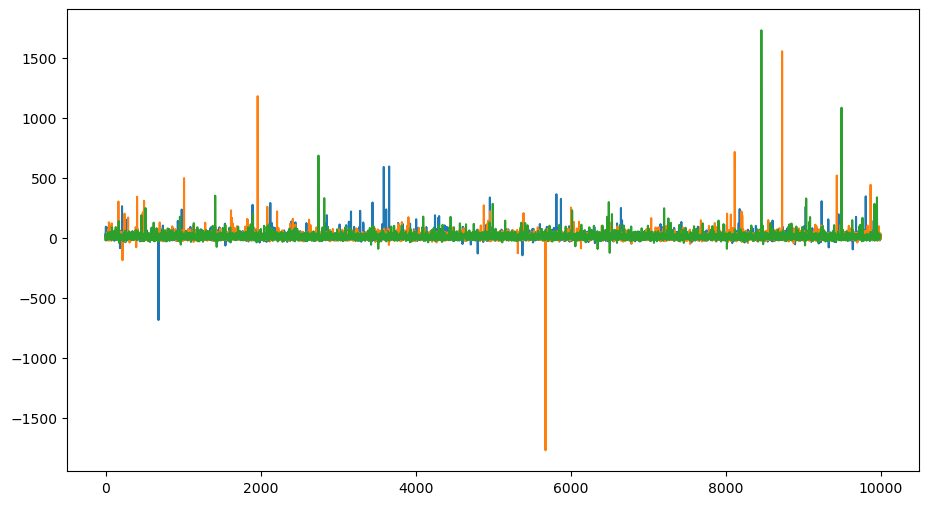

In [63]:
# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs);

# To illustrate the stochasticity, we ploted a couple of more observations with the same parameters:
plt.plot(generation(n,alpha=1.7, beta=0.9, gamma=10, delta=10));
plt.plot(generation(n,alpha=1.7, beta=0.9, gamma=10, delta=10));

<code style="background:LightBlue;color:white"> <strong><em> RQMC sequences </em> </strong> 

In [ ]:
#Method 1 using Stratification

In [75]:
def stratified_sampling(a, b, N, K, method='uniform'):
    """
    Generate stratified samples over a specified interval [a, b].
    
    Args:
        a (float): Lower bound of the interval.
        b (float): Upper bound of the interval.
        N (int): Total number of samples to generate.
        K (int): Number of strata.
        method (str): Method of sampling within strata ('uniform', 'single_point', 'middle').

    """
    samples = []
    interval_length = (b - a) / K

    for k in range(K):
        # Calculate the bounds of the k-th interval
        low = a + k * interval_length
        high = low + interval_length

        if method == 'uniform':
            # Generate N/K samples within this interval
            samples.extend(np.random.uniform(low, high, size=N//K))
        elif method == 'single_point':
            # Generate one random sample in each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                samples.append(np.random.uniform(low, high))
            else:
                raise ValueError("N must be equal to K for 'single_point' sampling method.")
        elif method == 'middle':
            # Use the midpoint of each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                midpoint = (low + high) / 2
                samples.append(midpoint)
            else:
                raise ValueError("N must be equal to K for 'middle' sampling method.")
        else:
            raise ValueError("Unsupported method. Choose 'uniform', 'single_point', 'middle'.")

    return np.array(samples)

In [76]:
def alpha_stable_sample_RQMC_stratification(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with zerros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    # Random shifts
    random_shift_U = np.random.uniform(-np.pi/2, np.pi/2)
    random_shift_W = np.random.uniform(0, 1)
    
    # Generate stratified U and W with random shift
    U = (stratified_sampling(-np.pi/2, np.pi/2, n, K=100, method='uniform') + random_shift_U) % (np.pi) - np.pi/2
    W = -np.log(1 - (stratified_sampling(0, 1, n, K=100, method='uniform') + random_shift_W) % 1)

    
    # Handle the case alpha = 1 separately
    if alpha != 1:
        part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
        part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
        sample = S_alpha_beta * part1 * part2
    else:
        sample = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [72]:
# Generate a sample
n=10000
y_rqmc1= alpha_stable_sample_RQMC_stratification(n,alpha=1.7, beta=0.9, gamma=10, delta=10)

In [ ]:
#Method 2 using Sobol

In [82]:
def alpha_stable_sample_RQMC_sobol(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Initialize a Sobol sequence generator with 2 dimensions
    sobol = qmc.Sobol(d=2, scramble=True)
    
    # Generate Sobol points scaled to the ranges of U and W
    points = sobol.random(n)
    # U ranges from -np.pi/2 to np.pi/2, and W is -log(1-U) where U is uniform(0,1)
    U = points[:, 0] * np.pi - np.pi / 2  # Scale first dimension for U
    W = -np.log(1 - points[:, 1])         # Scale second dimension for W

    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U[i] + B_alpha_beta)) / (np.cos(U[i]) ** (1 / alpha))
            part2 = (np.cos(U[i] - alpha * (U[i] + B_alpha_beta)) / W[i]) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U[i]) * np.tan(U[i]) - beta * np.log((np.pi / 2 * W[i] * np.cos(U[i]))/(np.pi/2 + beta * U[i])))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [85]:
# Generate a sample
n=10000
y_rqmc2 = alpha_stable_sample_RQMC_sobol(n,alpha=1.7, beta=0.9, gamma=10, delta=10)

In [87]:
# Apply function and calculate expectations
expect_rqmc = np.mean(np.exp(-y_rqmc2))
expect_mc = np.mean(np.exp(-y_obs))

# Display results
print("RQMC Expected Value: ", expect_rqmc)
print("MC Expected Value: ", expect_mc)

RQMC Expected Value:  7.55950077936132e+138
MC Expected Value:  2.4095071736243816e+293
